# 视觉皮层构架 The Architecture of the Visual Cortex

# 卷积层 Convolutional Layers

几个用来绘制灰度和 RGB 图像的函数

In [1]:
def plot_image(image):
    # "nearest" 分辨率不匹配时,只显示图像而不尝试在像素之间进行插值
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## TensorFlow实现

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

2021-12-20 15:05:47.043049: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-20 15:05:47.043176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


在`TensorFlow`中:
- 每个输入图像通常表示的形状为$[height,width,channels]$的3D张量
- 小批量表示为形状$[mini\ batch\ size,height,width,channels]$的4D张量
- 卷积层的权重可以表示为$[f_h,f_w,f_{n^{'}},f_n]$的4D张量
    - $f_h,f_w$表示接受野的高度和宽度
    - $f_{n^{'}},f_n$表示上一层中特征图个数和这一层中特征图个数
- 卷积层的偏置项简单表示为形状$[f_n]$的一维张量.

示例:加载两个样本图像,然后创建两个滤波器并将其应用于两个图像中,最后显示其中一个的结果特征图.

In [3]:
from sklearn.datasets import load_sample_image

1. 加载图像 

In [4]:
# 缩放像素强度到0~1的浮点数
china = load_sample_image("china.jpg") / 255     # shape:(427, 640, 3)
flower = load_sample_image("flower.jpg") / 255   # shape:(427, 640, 3)

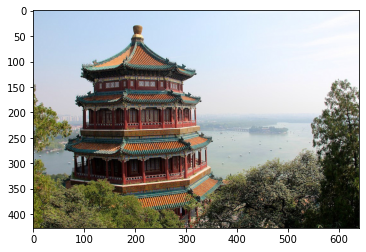

In [5]:
plt.imshow(china)
plt.show()

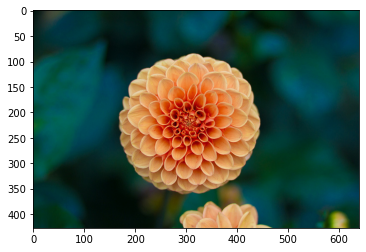

In [6]:
plt.imshow(flower)
plt.show()

In [7]:
# 将两幅图和成一个四维张量，表示有2个批次
images = np.array([china, flower])   # shape:(2, 427, 640, 3)
batch_size, height, width, channels = images.shape

2. 创建两个7*7的过滤器

In [8]:
# f_h=7(height), f_w=7(width)
# f_n′=channels=3   f_n=filters=2 
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

In [9]:
filters[:, 3, :, 0] = 1   # 中间有垂直白线
filters[3, :, :, 1] = 1   # 中间有水平白线

<img src="./images/other/14-1.png" width="300">

3. 使用`tf.nn.conv2d()`应用于两个图像.

In [10]:
# 使用0填充("SAME")和步长为1
outputs = tf.nn.conv2d(input=images, filters=filters, strides=1, padding="SAME")

2021-12-20 15:05:53.860774: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 15:05:53.863959: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-20 15:05:53.863998: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 15:05:53.864027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0b513a03f873): /proc/driver/nvidia/version does not exist
2021-12-20 15:05:53.866657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

> `tf.nn.conv2d()`参数详解
1. `images`是输入的小批量
2. `filter`是要应用的一组滤波器
3. `strides`等于1,但也可以是包含四个元素的一维度组,其中两个中间元素是垂直步幅和水平步幅($s_h$和$s_w$)。第一个元素和最后一个元素必须等于1。格式为:`[1,stride,stride,1]`.它们可能会用于指定`批处理步幅`(跳过某些实例)和`通道步幅`(跳过某些上一层的特征图或通道)
4. `padding`必须为`SAME`或`VALID`,
    - 如果设置为`SAME`,则卷积层在必要时使用**零填充**。将输出大小设置为**输入神经元的数量除以步幅(向上取整)所得的值**。例如,如果输入大小为13而步幅为5,则输出大小为3,然后根据需要在输入周围尽可能均匀地添加零。**当 `strides=1`时,层的输出将具有与其输入相同的空间尺寸(宽度和高度)**,因此命名为`SAME`.
        - `等宽卷积`:步长$S=1$,两端补零$P=\frac{K-1}{2}$,卷积输出长度为$M$
    - 如果设置为`VALID`,则卷积层将**不使用零填充**,并且可能会忽路输入图像底部和右侧的某些行和列,具体取决于步幅,这意味着每个神经元的接受野都严格位于输入内部的有效位置内(不会超出范围),因此命名为`VALID`.
        - `窄卷积`:步长$S=1$,$P=0$,卷积输出长度为$M-K+1$

4. 绘制整体结果特征图

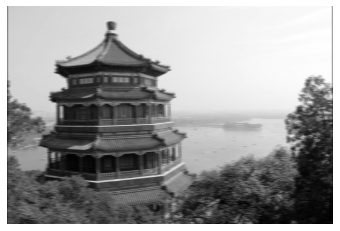

In [11]:
# 绘制第一张china图像的第二个特征图
plt.imshow(outputs[0,:,:,1], cmap="gray")    # outputs_shape: [2,427,640,2]
plt.axis("off")
plt.show()

<img src="./images/other/14-3.png" width="500">

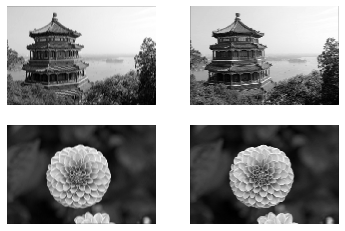

In [12]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2,image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index,:,:,feature_map_index])
        
plt.show()

5. 观察局部特征

In [13]:
def crop(images):
    return images[150:220, 130:250]

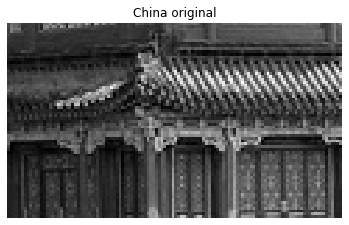

In [14]:
plot_image(crop(images[0, :, :, 0]))
plt.title("China original")
plt.show()

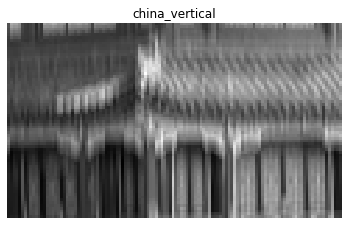

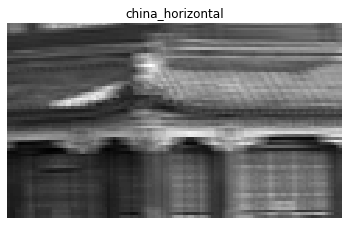

In [15]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    plt.title(filename)
    plt.show()

6. 观察滤波器

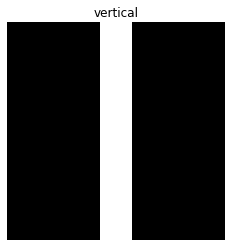

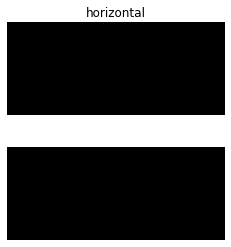

In [16]:
plot_image(filters[:, :, :, 0])
plt.title("vertical")
plt.show()
plot_image(filters[:, :, :, 1])
plt.title("horizontal")
plt.show()

## Conv2D

以上的实例,我们手动定义了滤波器,但是在实际的`CNN`中,通常将滤波器定义为可训练的变量,卷积层在训练时会在学习适当的过滤器和偏置的参数.

- 使用`keras.layers.Conv2D`层

In [17]:
initialization()

conv = keras.layers.Conv2D(filters=2,       # 滤波器数量
                           kernel_size=7,   # 滤波器宽高
                           strides=1, 
                           padding="SAME",
                           activation=keras.activations.relu,
                          )

后续可以使用交叉验证来找到正确的超参数的值.

In [18]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

- 绘制特征图

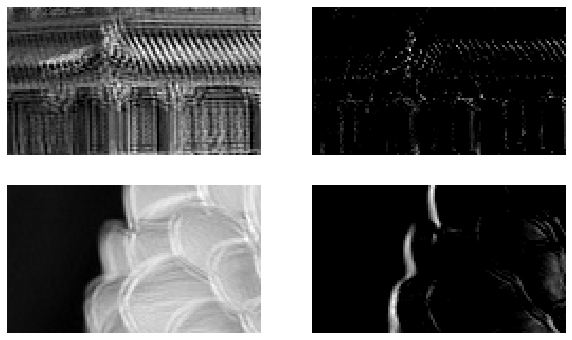

In [19]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

尽管过滤器是随机初始化的，但第二个过滤器恰好充当边缘检测器.

- 手动设置过滤器参数

In [20]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1   # 中间有垂直白线
filters[3, :, :, 1] = 1   # 中间有水平白线

In [21]:
conv.set_weights([filters, np.zeros(2)])  # 偏置设置为0

In [22]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

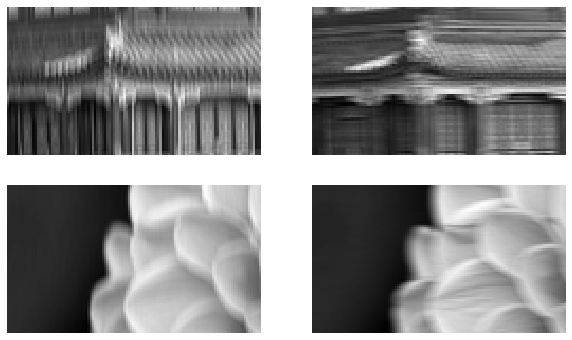

In [23]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## `SAME` 与 `VALID`

> 假设卷积层的输入神经元个数为$M$,卷积大小为$K$,步长为$S$,在输入两端各填补$P$个0,那么该卷积层的输出长度为$\frac{M-K+2P}{S}+1$.

`padding`必须为`SAME`或`VALID`,
- 如果设置为`SAME`,则卷积层在必要时使用**零填充**。将输出大小设置为**输入神经元的数量除以步幅(向上取整)所得的值**。例如,如果输入大小为13而步幅为5,则输出大小为3,然后根据需要在输入周围尽可能均匀地添加零。**当 `strides=1`时,层的输出将具有与其输入相同的空间尺寸(宽度和高度)**,因此命名为`SAME`.
     - `等宽卷积`:步长$S=1$,两端补零$P=\frac{K-1}{2}$,卷积输出长度为$M$
- 如果设置为`VALID`,则卷积层将**不使用零填充**,并且可能会忽路输入图像底部和右侧的某些行和列,具体取决于步幅,这意味着每个神经元的接受野都严格位于输入内部的有效位置内(不会超出范围),因此命名为`VALID`.
    - `窄卷积`:步长$S=1$,$P=0$,卷积输出长度为$M-K+1$

In [24]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1      # SAME
    else:
        return (input_size - kernel_size) // strides + 1   # VALID

In [25]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [26]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [27]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# 需要调用 build() 以便创建 conv_same 的权重
conv_same.build(tf.TensorShape(images.shape))

# 将权重从 conv_valid 复制到 conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

# np.allclose: 比较两个array是不是每一元素都相等
assert np.allclose(valid_output.numpy(), same_output.numpy())

使用 `SAME` 填充相当于使用 `manual_same_padding()`,然后使用 `VALID` 填充.

## 特征图的行列数计算

对于 $n × n$ 的矩阵, 使用 $f×f$ 的核进行卷积, 填充宽度为 $p$, 若纵向步幅为 $s _1$, 横向步幅为 $s_2$则特征图的行列数为:
$$
\left[\frac{n+2p-f}{s_1}+1\right] \times\left[\frac{n+2 p-f}{s_2}+1\right]
$$

In [28]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.],
                 [7., 8., 9.]
                ]) 
# x.shape : TensorShape([3, 3])

x = tf.reshape(x, [1,3,3,1])  # (batch_size, height, width, channels)

In [29]:
x

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]], dtype=float32)>

In [30]:
conv = keras.layers.Conv2D(filters=1,       # 滤波器数量
                           kernel_size=2,   # 滤波器宽高
                           strides=1, 
                           padding="VALID",
                           activation=keras.activations.relu,
                          )

In [31]:
conv(x).shape # n(3,3) +2* p(0,0) - f(2,2) / s(1,1) +(1,1)  ==> (2,2)

TensorShape([1, 2, 2, 1])

# 池化层 Pooling layer

`池化层`的目标是对输入图像进行下采样,以便减少计算量,内存使用量和参数数量(从而降低过拟合的风险).

此外,还为引入了一定程度的`小变换不变性`,这在分类任务这样的不依赖于这些细节的预测会很有用.

<img src="./images/other/14-4.png" width="400">

最大池化存在一些缺点:非常具有破坏性;在某些应用中`小变换不变性`不可取,如语义分割.

`Mean Pooling`层曾经非常流行，但现在人们大多使用`Max Pooling`层，因为它们通常表现更好。这似乎令人惊讶，因为计算平均值通常比计算最大值丢失的信息少。但另一方面，`Max Pooling`只保留最强的特征，而将无意义的特征去除，因此下一层得到更清晰的信号来使用。而且，`Max Pooling`提供比`Mean Pooling`更强的平移不变性，并且它需要的计算量略少。

In [32]:
cropped_images = np.array([crop(image) for image in images])

## Max pooling

- 使用`keras.layers.MaxPool2D`层

    使用2×2的内核创建一个最大池化层:步幅默认为内核大小,默认使用`VALID`填充.

In [33]:
max_pool = keras.layers.MaxPooling2D(pool_size=2)

In [34]:
output_Max_pool = max_pool(cropped_images)

In [35]:
def plot_input_output(inputImages, outputImages, ratios=[1,1]):
    fig = plt.figure(figsize=(12, 8))
    # GridSpec:用于指定放置子图的网格的几何形状
    # 参数width_ratios:相对宽度比例 width_ratios[i] / Σwidth_ratios
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=ratios)

    # 绘制输入图像
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Input")
    ax1.imshow(inputImages)  
    ax1.axis("off")

    # 绘制输出图像
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Output")
    ax2.imshow(outputImages, cmap="gray", interpolation="nearest")  
    ax2.axis("off")     

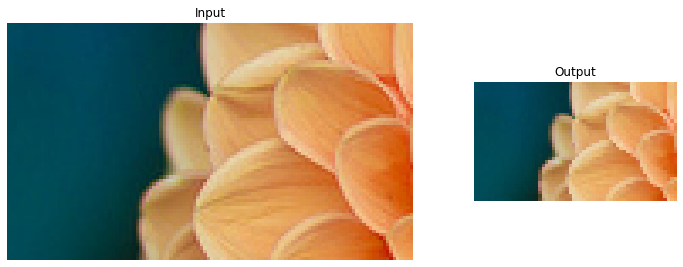

In [36]:
plot_input_output(cropped_images[1], output_Max_pool[1], [2,1])
plt.show()

## Depth-wise pooling

`Depth-wise pooling`可以让`CNN`学习到多种不变性.
<img src="./images/other/14-5.png" width="300">
`Keras`中没有`Depth-wise pooling`,可以使用TF中的低级API:`tf.nn.max_pool`.

`tf.nn`，`tf.layers`， `tf.contrib`模块有很多功能是重复的

下面是对三个模块的简述：
- `tf.nn` ：提供神经网络相关操作的支持，包括卷积操作（conv）、池化操作（pooling）、归一化、loss、分类操作、embedding、RNN、Evaluation。
- `tf.layers`：主要提供的高层的神经网络，主要和卷积相关的，tf.nn会更底层一些。
- `tf.contrib`：`tf.contrib.layers`提供够将计算图中的 网络层、正则化、摘要操作、是构建计算图的高级操作，但是`tf.contrib`包含不稳定和实验代码，有可能以后API会改变。


方法1:创建一个自定义的`Keras`层

In [37]:
class DeptMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(input=images,
                              ksize=(1,1,1,self.pool_size),
                              # 依次为沿批次,高度,宽度,深度的步长/核大小
                              # 深度的步长/核大小必须可以整除输入深度
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)  

方法2:使用`Lambda`层

In [38]:
depth_pool = keras.layers.Lambda(lambda X:tf.nn.max_pool(
                                  input=X,
                                  ksize=(1, 1, 1, 3),
                                  strides=(1, 1, 1, 3),
                                  padding="VALID")  
                                )

In [39]:
with tf.device("/cpu:0"):    # 指定模型运行的具体设备
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

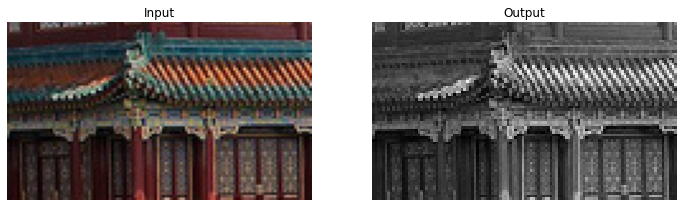

In [40]:
plot_input_output(cropped_images[0], depth_output[0, ..., 0])

## Average pooling

In [41]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_Avg_pool = avg_pool(cropped_images)

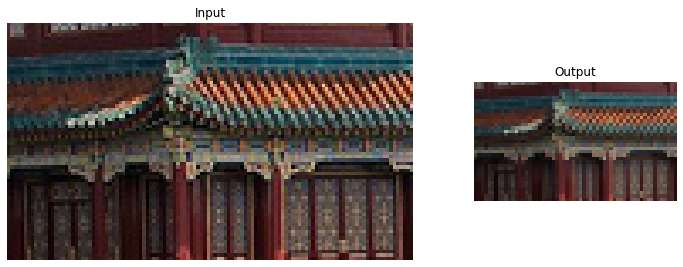

In [42]:
plot_input_output(cropped_images[0], output_Avg_pool[0], [2,1])

## Global Average Pooling

`Global Average Pooling`是将每一张特征图计算所有像素点的均值，输出一个数据值.被认为是可以替代全连接层的一种新技术，将这些特征点组成最后的特征向量，进行`softmax`中进行计算.

In [43]:
global_avg_pool_1 = keras.layers.GlobalAvgPool2D()
global_avg_pool_1(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

等价于以下`Lambda`层:计算空间维度（高度和宽度）的平均值.

In [44]:
output_global_avg_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg_2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# CNN架构 CNN Architectures

<img src="./images/other/14-6.png" width="500">

## 使用CNN处理MNIST数据集

以下是实现简单的`CNN`来处理`Fashion MNIST`数据集的方法.

In [45]:
initialization()

In [46]:
# 1. 加载数据集
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full,y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. 特征缩放
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# 3. 创建验证集
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

# 4. 输入标准化
pixel_mean = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train-pixel_mean) / pixel_std
X_val = (X_val-pixel_mean) / pixel_std
X_test = (X_test-pixel_mean) / pixel_std

X_train.shape, X_val.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [47]:
# 5. 添加提个维度 ->( batch_size, height, width, channels )
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape

(55000, 28, 28, 1)

In [48]:
# 7. 配置云端TPU
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-12-20 15:05:59.505791: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-20 15:05:59.505860: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30043}
2021-12-20 15:05:59.521592: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-20 15:05:59.521652: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30043}
2021-12-20 15:05:59.522111: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30043


REPLICAS:  8


In [49]:
# 8. 创建模型
from functools import partial

default_Conv2D_layer = partial(keras.layers.Conv2D,
                               kernel_size=3,
                               activation=keras.activations.relu,
                               padding='SAME')

with strategy.scope():
    model = keras.models.Sequential([
        default_Conv2D_layer(filters=64, kernel_size=7, 
                             input_shape=[28,28,1]),
        keras.layers.MaxPooling2D(pool_size=2),
        default_Conv2D_layer(filters=128),
        default_Conv2D_layer(filters=128),
        keras.layers.MaxPooling2D(pool_size=2),
        default_Conv2D_layer(filters=256),
        default_Conv2D_layer(filters=256),    
        keras.layers.MaxPooling2D(pool_size=2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation=keras.activations.softmax),
    ])

- 第一层使用64个相当大的滤波器(7×7),但没有步幅,因为输入图像不是很大.


- 接下来,我们有一个`MaxPooling`层,池化大小为2,因此它将每个空间维度除以2


- 然后我们重复相同的结构两次:两个卷积层,紧接着是一个`MaxPooling`层。对于较大的图像,我们可以重复多次此结构.


- 请注意随着`CNN`向输出层延伸,滤波器的数量会增加:增长是有意义的,因为低层特征的数量通常很少(例如小圆圈、水平线),但是有很多不同的方法可以将它们组合成更高层次的特征。通常的做法是在每个`Pooling`层之后将滤波器的数量加倍:由于池化层将每个空间维度除以2,所以我们能负担得起对下一层特征图数量加倍而不必担心参数数量、内存使用量或计算量的暴增.


- 接下来是全连接的网络,该网络由两个隐藏的密集层和一个密集输出层组成。请注意,我们必须将其输入`Flatten`展平,因为密集网络需要每个实例的一维特征阵列,我们还加了两个`dropout`层,每层的`dropout`率均为50%,以减少过拟合的情况.

In [50]:
#keras.utils.plot_model(model, "./models/plot_model/CNN_example_model.png", show_shapes=True)

In [51]:
# 9. 编译模型
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [52]:
# 10. 训练模型
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
1719/1719 [==============================] - 39s 18ms/step - loss: 1.0235 - sparse_categorical_accuracy: 0.6349 - val_loss: 0.4165 - val_sparse_categorical_accuracy: 0.8468
Epoch 2/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.4489 - sparse_categorical_accuracy: 0.8499 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.8754
Epoch 3/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.3716 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.2948 - val_sparse_categorical_accuracy: 0.8932
Epoch 4/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3237 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.8886
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.3065 - val_sparse_categorical_accuracy: 0.8908
Epoch 6/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.

In [53]:
# 9. 评估模型
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] 
y_pred = model.predict(X_new)

313/313 [==============================] - 5s 14ms/step - loss: 0.2958 - sparse_categorical_accuracy: 0.9041


## LeNet-5